# Generating MIDI notes via RNNs

After we have taken a look how we train RNNs on a certain text corpora and use it to continue a given text we want to see how we can modify this method so we instead can use it for a musical notation.
At the end we want to use our model in real time with SuperCollider by using a MIDI keyboard.

Where in a classical written text the notation only works singulary in one direction the musical score also allows for events happening in paralell at the same time like chords or melodies in multiple instruments.
We assume that the number of paralell events is not per-determined and dynamic which makes it difficult to account for in mathematical notation.
For this reason we will limit ourselves to monophonic melodies as corpora.

In [ ]:
import glob
from typing import List

import numpy as np
import music21
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

mpl.rcParams['figure.figsize'] = (15, 5)
np.random.seed(42)

## Loading the data

As mentioned above to keep things simple for now we will restrict ourselves to monophonic melodies.
As we don't want to spend too much time on obtaining and filtering we will simply use easily available monophonic melodies - and we also need as much as possible as this is machine learning with neural networks.
With such requirements we often tend to use works from J.S. Bach as those are quite easily representable in MIDI format, there are no licensing issues, there is a huge fanbase who transcribed everything into MIDI format and it offers a big and homogenous corpora.

As corpora we will use the [Suites for Solo Cello](https://en.wikipedia.org/wiki/Cello_Suites_(Bach)) which are available in MIDI format [here](http://www.jsbach.net/midi/midi_solo_cello.html) but are already included in this repository as well.

In [ ]:
midi_files = glob.glob("assets/bach-midi/*.mid")
random_midi_file = np.random.choice(midi_files)

print(f"Loaded {len(midi_files)} MIDI files. Random selected file is '{random_midi_file}'")

Loaded 36 MIDI files. Random selected file is 'assets/bach-midi/cs5-2all.mid'


If you have [MuseScore](https://musescore.org) installed on your system we can transform the MIDI file to score notation within Python via music21.

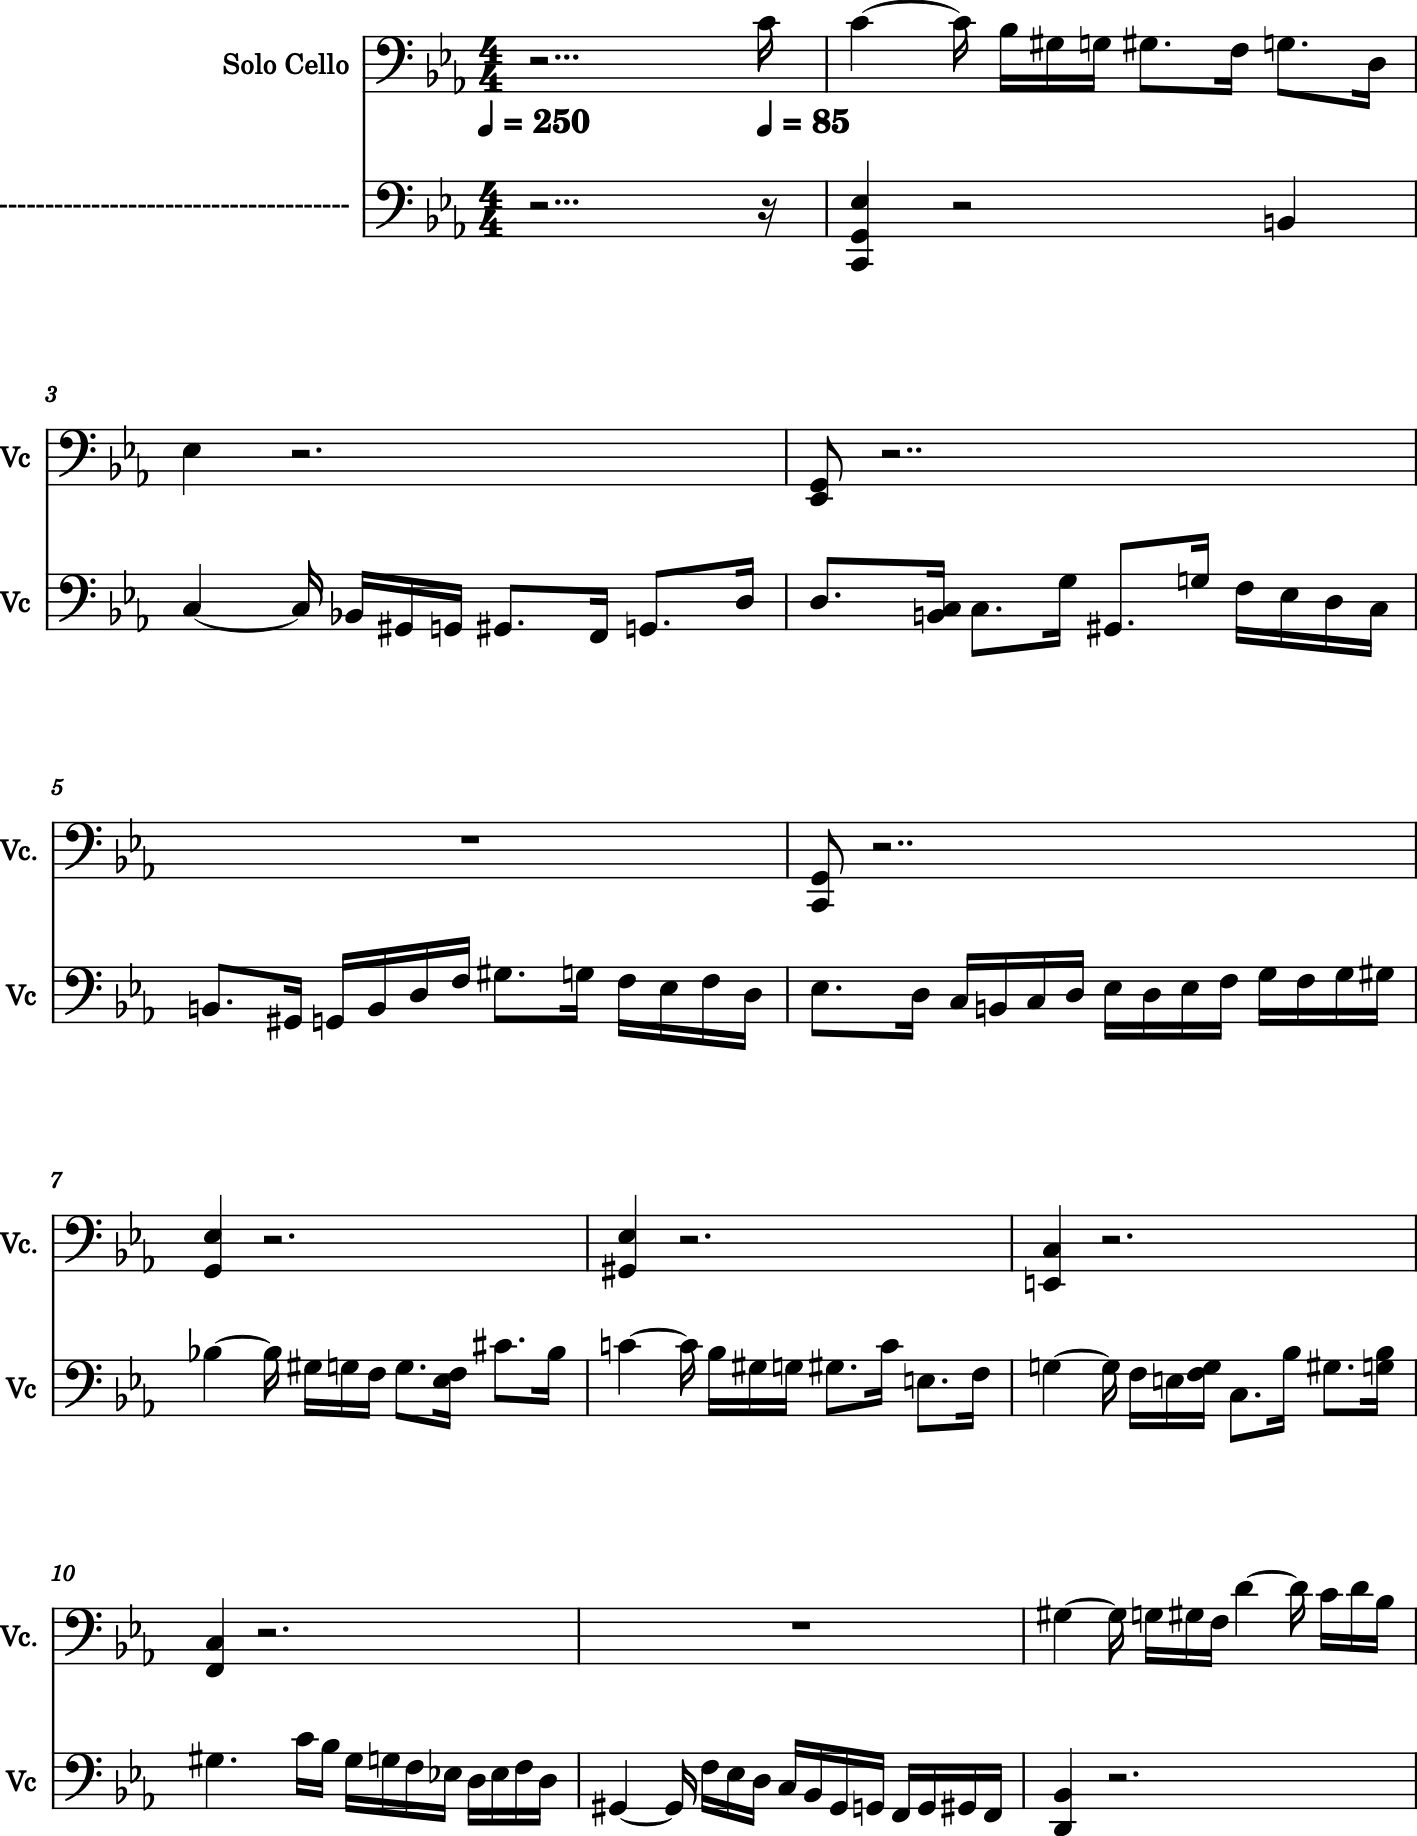

In [ ]:
music21.converter.parse(random_midi_file).show()

Although we restricted ourselves to a single instrument we notice that the Cello is not played solely monophonic and we need to think of a way how to restrict our data to strictly monophonic sequences.
For now we wil simply will only take take the upmost note and ignore the others.

We also need to think of a way to encode the MIDI notation into a text representation.
For note pitches this is somehow trivial as we can simply take the [MIDI pitch number](https://newt.phys.unsw.edu.au/jw/notes.html) which we also often use in SuperCollider.
The duration of a note can be expressed as a fraction of quarter notes which will also allow us to encode arbitrary tuplets.
To transform the data we will write a function `extract_notes` which uses [music21](https://web.mit.edu/music21/) to extract the necesarry data.

In [ ]:
def extract_notes(midi_file_path:str, mono:bool = True):
    notes = []
    durations = []

    for e in music21.converter.parse(midi_file_path).chordify().flat:
        if isinstance(e, music21.chord.Chord):
            if mono:
                # only use highest pitch
                notes.append(str(sorted(e.pitches)[::-1][0].midi))
            else:
                # concat ptiches via ,
                notes.append(','.join([str(n.midi) for n in e.pitches]))
            durations.append(e.duration.quarterLength)

        if isinstance(e, music21.note.Note):
            notes.append(str(e.midi))
            durations.append(e.duration.quarterLength)
        
    return notes, durations

In [ ]:
notes, durations = extract_notes(random_midi_file)
print(f"Notes ({len(notes)}):\t\t{notes[0:10]}")
print(f"Duractions ({len(durations)}):\t{durations[0:10]}")

Notes (683):		['60', '60', '60', '58', '56', '55', '56', '53', '55', '50']
Duractions (683):	[0.25, 1.0, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25]


We want to verify if our extraction works as expected by creating a MIDI file from it again via music21.

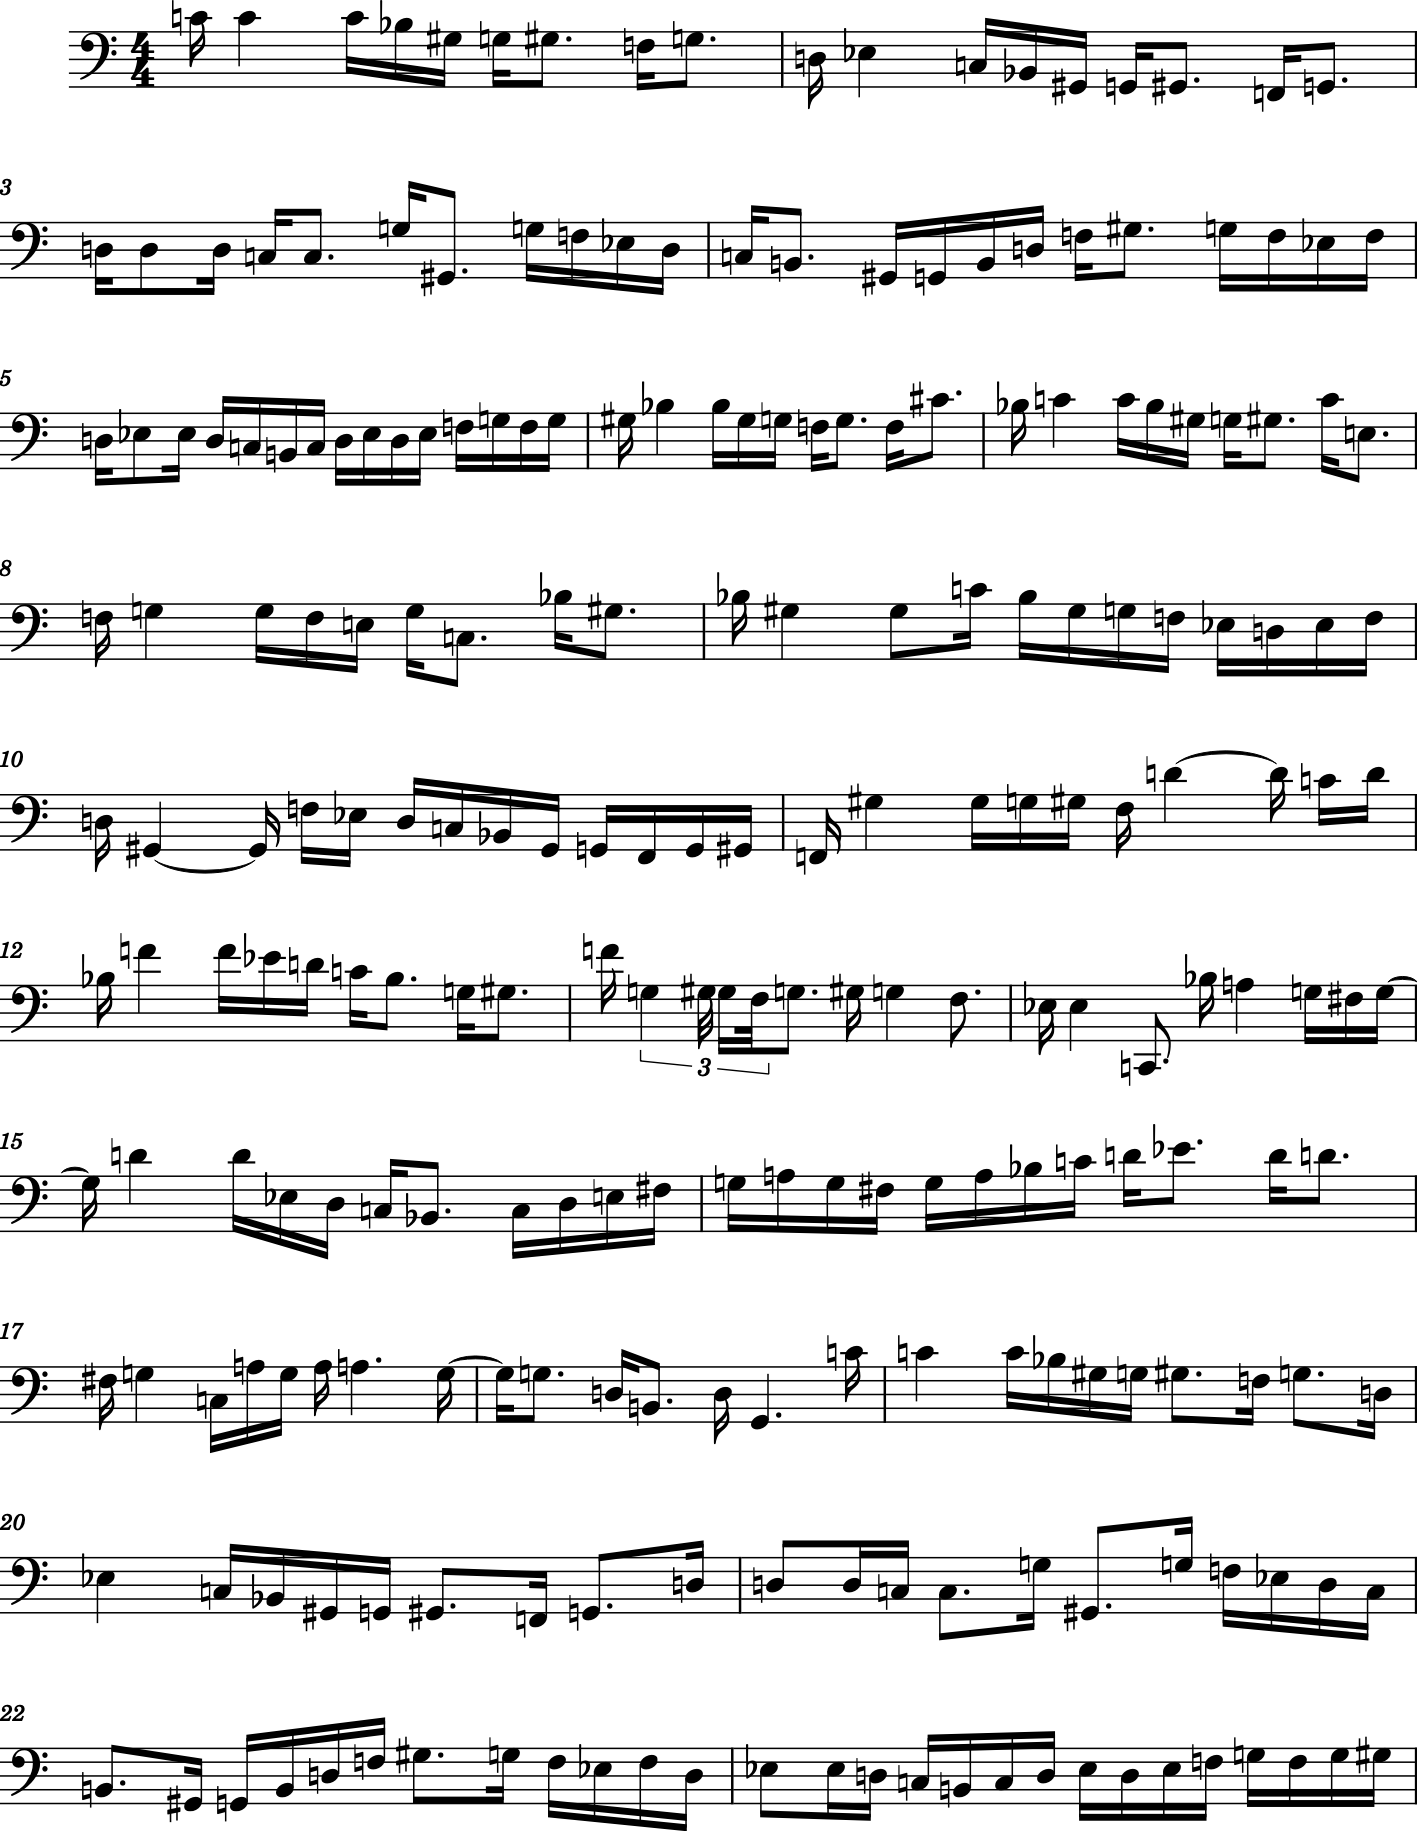

In [ ]:
stream = music21.stream.Stream()

for n, d in zip(notes, durations):
    note = music21.note.Note(int(n))
    note.duration.quarterLength = d
    stream.append(note)

stream.show()

We see that [ties](https://en.wikipedia.org/wiki/Tie_(music)) were completely ignored which is far from perfect - also some timing (bar 13) seems pretty off as we not have observed such strange timing in our original material.
Normally we would need to spend much more time on this endeavour as this is the only data that our neural network is given and its bad if it contains avoidable mistakes.
Also, in my experience, it would be best **not** to use music21 for this as it contradicts common Python schemes and makes it therefore tedious to work with and is also slow if working on a big dataset.
Nontheless it is an interesting library which offers lots of functionallity for traditional western classical music.

For now we will ignore all the flaws of our conversion function (we also could it expand this function to convert everything to the same key - but the question is if this is something we really want).

In [ ]:
notes = []
durations = []

for midi_file in midi_files:
    print(f'parse {midi_file}')
    n, d = extract_notes(midi_file, mono=True)
    notes.append(n)
    durations.append(d)

parse assets/bach-midi/cs1-2all.mid
parse assets/bach-midi/cs5-1pre.mid
parse assets/bach-midi/cs4-1pre.mid
parse assets/bach-midi/cs3-5bou.mid
parse assets/bach-midi/cs1-4sar.mid
parse assets/bach-midi/cs2-5men.mid
parse assets/bach-midi/cs3-3cou.mid
parse assets/bach-midi/cs2-3cou.mid
parse assets/bach-midi/cs1-6gig.mid
parse assets/bach-midi/cs6-4sar.mid
parse assets/bach-midi/cs4-5bou.mid
parse assets/bach-midi/cs4-3cou.mid
parse assets/bach-midi/cs5-3cou.mid
parse assets/bach-midi/cs6-5gav.mid
parse assets/bach-midi/cs6-6gig.mid
parse assets/bach-midi/cs6-2all.mid
parse assets/bach-midi/cs2-1pre.mid
parse assets/bach-midi/cs3-1pre.mid
parse assets/bach-midi/cs3-6gig.mid
parse assets/bach-midi/cs2-6gig.mid
parse assets/bach-midi/cs2-4sar.mid
parse assets/bach-midi/cs3-4sar.mid
parse assets/bach-midi/cs1-5men.mid
parse assets/bach-midi/cs1-3cou.mid
parse assets/bach-midi/cs6-1pre.mid
parse assets/bach-midi/cs2-2all.mid
parse assets/bach-midi/cs3-2all.mid
parse assets/bach-midi/cs1-1

## Convert data to sequences

As RNNs predict the next sample $x_{m+n+1}$ based on previous $n$ examples $\lbrace x_m, x_{m+1}, \dots, x_{m+n} \rbrace$ (where $m \in \mathbb{N}$ is an arbitrary offset within our data sequenece) we need to prepare our data in such a way as well.
We can simply copy the function from the text RNN for this.

In [ ]:
def generate_sequences(notes: List[int], durations: List[int], seq_length: int) -> List[np.ndarray]:
    X_notes = []
    X_dur = []
    y_notes = []
    y_dur = []
    
    for note, duration in zip(notes, durations):
        for i in range(0, len(note) - seq_length):
            X_notes.append(note[i:i+seq_length])
            y_notes.append(note[i+seq_length])
            
            X_dur.append(duration[i:i+seq_length])
            y_dur.append(duration[i+seq_length])
    
    # we specify the data type of our data to save some memory which is crucial when working with neural networks
    return np.array(X_notes, dtype=np.int16), np.array(y_notes, dtype=np.int16), np.array(X_dur, dtype=np.float16), np.array(y_dur, dtype=np.float16)

X_n, y_n, X_d, y_d = generate_sequences(notes, durations, seq_length=64)

For each of our 2 sequences (one sequence are the pitch names, the other one the durations) we created an array $X$ which will contain $64$ samples and a vector $y$ which will contain the next sample, which is exactly what our neural network shall predict.

In [ ]:
print(f"X_n {X_n.shape}:\n{X_n[0]}")
print(f"X_d {X_d.shape}:\n{X_d[0]}")
print()
print(f"y_n {y_n.shape}: {y_n[0]}")
print(f"y_d {y_d.shape}: {y_d[0]}")

X_n (25132, 64):
[59 59 59 57 55 54 55 50 52 54 55 57 59 60 62 59 55 54 55 52 50 48 47 48
 50 52 54 55 57 59 60 57 55 54 55 52 54 55 45 50 54 55 57 59 60 57 59 55
 55 50 50 47 47 43 43 59 60 59 57 55 57 59 60 57]
X_d (25132, 64):
[0.25 1.   0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.75 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]

y_n (25132,): 55
y_d (25132,): 0.25


As with our text and with the MNIST example we actually don't want to predict the next sample but the probability of each possible class (also called [probability distribution](https://en.wikipedia.org/wiki/Probability_distribution)).
Therefore we need to transfer our vector $y$ (which has as many dimension as we have samples in $X$) to a so called [one hot encoding](https://en.wikipedia.org/wiki/One-hot) vector, transforming $y$ to a matrix of dimensions *number of samples* $\times$ *number of classes*.

For our pitches we can use some knowledge such as that there are only 127 possible pitch classes and the pitches next to each other are also mapped next to each other on our integer encoding.
Preserving this structure makes it easier for the neural network to look for a structure within our data and also allows us to debug the data more easily.

We will add the suffix `_h` for the one-hot-encoded version of our data.

In [ ]:
y_n_h = np.eye(127)[y_n]

In [ ]:
print(y_n[0])
print(y_n_h[0])

55
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


Doing th same for the durations is not as easy as we do not know beforehand what kind of durations are within our data - although we can be sure that it contain only a finite number of discrete values as our data is finite as well.

To keep things simple we will rely on a build in function [`OneHoteEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) from sklearn wich will not preserve the order of our durations but we also need to make this step reversible and therefore it is good to use exsisting solutions which we can save as well.

In Python it is possible to save variables to a file and load a variable from file as well (which is called [*pickling*](https://docs.python.org/3/library/pickle.html) - but be aware, such things are handy but a real security nightmare).
This comes in handy now as we need to save and restore this encoder as we need to save it as well as our model because it is our dictionary for durations outside of the neural network and within the neural network.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pickle
import os

encoder_file = 'assets/bach-model/dur_encoder.pkl'

# if file exists we load the exsiting encoder
if os.path.isfile(encoder_file):
    with open(encoder_file, 'rb') as f:
        dur_encoder = pickle.load(f)
    print(f"Loaded encoder from {encoder_file}")
# otherwhise we will create one
else:
    dur_encoder = OneHotEncoder(sparse=False)
    dur_encoder.fit(np.append(X_d.flatten(), y_d).reshape(-1, 1))
    # and save it so we can restore it later
    with open(encoder_file, 'wb') as f:
        pickle.dump(dur_encoder, f)
    print(f"Saved encoder to {encoder_file}")


Saved encoder to assets/bach-model/dur_encoder.pkl


Now we can use this encoder to transform our durations into a one-hot encoding.

In [ ]:
y_d_h = dur_encoder.transform(y_d.reshape(-1, 1))
y_d_h = np.array(y_d_h)

print("Categories: \n", dur_encoder.categories_[0])
print("\nFirst 10 items")
for i, y in zip(y_d[0:10], y_d_h[0:10]):
    print(i, '\t', y)

Categories: 
 [0.0833 0.1666 0.25   0.3333 0.5    0.6665 0.75   1.     1.25   1.333
 1.5    1.75   2.     2.25   2.5    3.     4.    ]

First 10 items
0.25 	 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25 	 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25 	 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25 	 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.75 	 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25 	 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25 	 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25 	 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25 	 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.25 	 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Writing the RNN

After we have prepared the data we can write a model which can be trained on the sequence and can be used to predict the continuation of new, unseen sequences.
Note that we will predict 2 sequences at once in one model instead of having a model for pitch and one for duration.
This allows that the neural network can learn co-relations between the pitch and time domain.

Below is a graph which shows the in- and output of the network and of each layer.

In [ ]:
# intermediate layer 
embed_size = 40

# num of possible outcomes for each y class
num_notes = y_n_h.shape[-1]
num_durs = dur_encoder.categories_[0].shape[0]

# the 2 input layers for the model
# shape None b/c the first dimension is the batch size used during training
notes_in = layers.Input(shape=(None,))
durs_in = layers.Input(shape=(None,))

# let the neural net transform the data itself via an embedding layer
x1 = layers.Embedding(num_notes, embed_size)(notes_in)
x2 = layers.Embedding(num_durs, embed_size)(durs_in)

# combine both embeddings
x = layers.Concatenate()([x1, x2])
# stack two lstm layers
x = layers.LSTM(256, return_sequences=True)(x)
x = layers.LSTM(256)(x)

# now create a dense layer for each output
notes_out = layers.Dense(num_notes, name='notes', activation='softmax')(x)
durs_out = layers.Dense(num_durs, name='durs', activation='softmax')(x)

# as our model has multiple in- and outputs we will use a new notation in keras
model = keras.Model([notes_in, durs_in], [notes_out, durs_out], name='bach_model')

model.summary()

Model: "bach_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 40)     5080        ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 40)     680         ['input_4[0][0]']                
                                                                                         

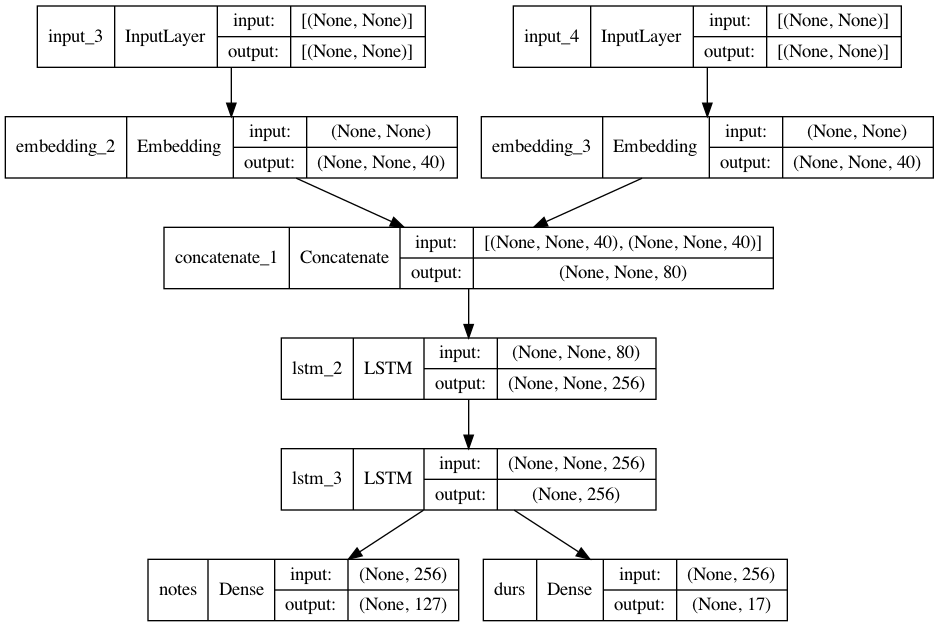

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

To finalize the model we need to define the rules for a successful learning which is in both cases a [categorical cross entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/) as we want to predict the distribution of the next pitch and duration.

In [ ]:
from keras.optimizer_v2.rmsprop import RMSprop

model.compile(
    loss=['categorical_crossentropy', 'categorical_crossentropy'],
    optimizer=RMSprop(learning_rate=0.001),
)

## Training

The actual training of the model is not much code thanks to our preparations - although it will consume time.
We will also save the model and in case the saved model exists we will use the existing model instead of training it from scratch.

Start traning model
Epoch 1/50
393/393 [==============================] - 86s 207ms/step - loss: 4.0639 - notes_loss: 2.9685 - durs_loss: 1.0954
Epoch 2/50
393/393 [==============================] - 85s 215ms/step - loss: 3.5703 - notes_loss: 2.6235 - durs_loss: 0.9468
Epoch 3/50
393/393 [==============================] - 89s 227ms/step - loss: 3.2504 - notes_loss: 2.4973 - durs_loss: 0.7531
Epoch 4/50
393/393 [==============================] - 93s 235ms/step - loss: 2.9522 - notes_loss: 2.3601 - durs_loss: 0.5921
Epoch 5/50
393/393 [==============================] - 103s 261ms/step - loss: 2.7139 - notes_loss: 2.2196 - durs_loss: 0.4943
Epoch 6/50
393/393 [==============================] - 110s 281ms/step - loss: 2.4853 - notes_loss: 2.0614 - durs_loss: 0.4239
Epoch 7/50
393/393 [==============================] - 116s 296ms/step - loss: 2.2540 - notes_loss: 1.8891 - durs_loss: 0.3649
Epoch 8/50
393/393 [==============================] - 103s 263ms/step - loss: 2.0131 - notes_loss: 1.7

2021-12-28 19:10:02.518097: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: assets/bach-model/v01/assets


INFO:tensorflow:Assets written to: assets/bach-model/v01/assets


Finished training - saved to assets/bach-model/v01


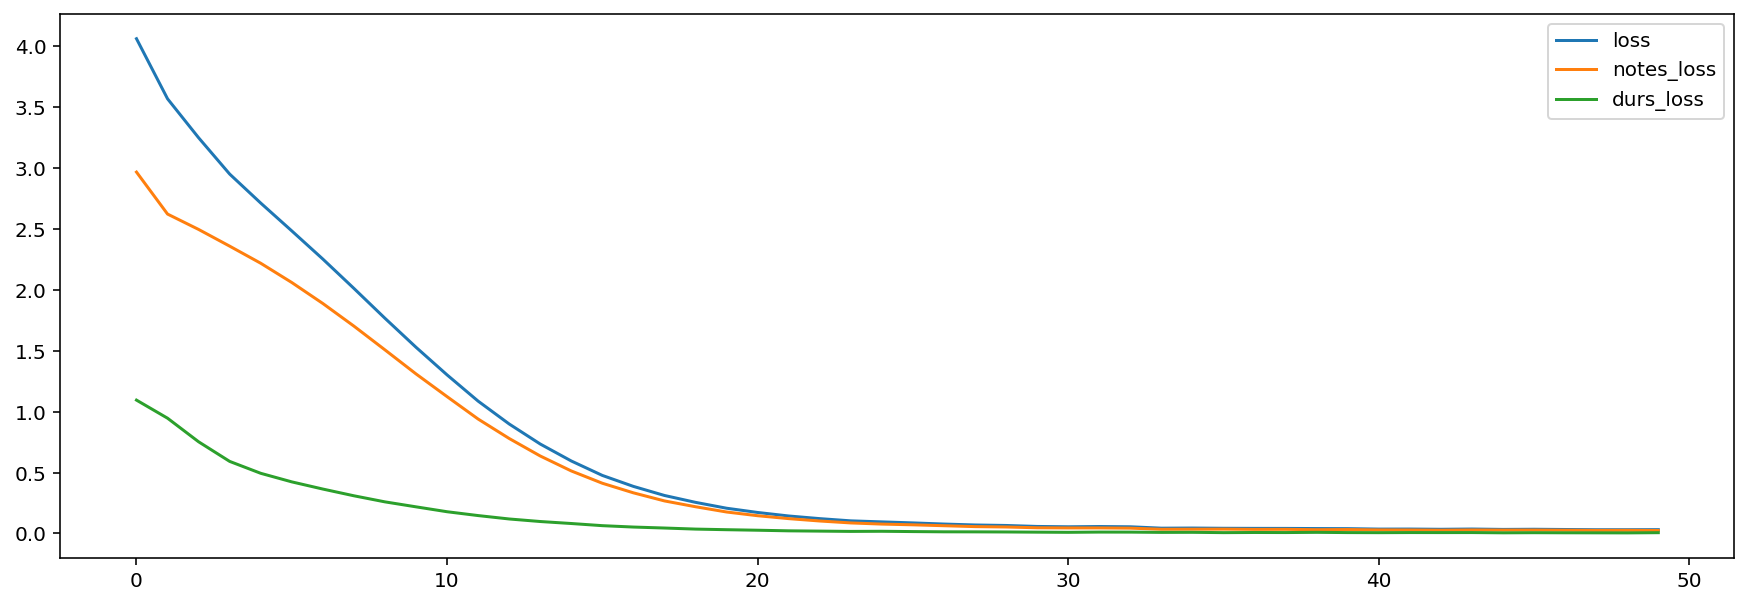

In [ ]:
model_path = 'assets/bach-model/v01'

if os.path.isdir(model_path):
    model = keras.models.load_model(model_path)
    print(f"Loaded model {model_path}")
else:
    print(f"Start traning model")
    model.fit([X_n, X_d], [y_n_h, y_d_h], epochs=50, batch_size=64, shuffle=True)
    model.save(model_path)
    print(f"Finished training - saved to {model_path}")
    pd.DataFrame(model.history.history).plot.line()

## Predict

After we have trained the neural network we want to see how we can continue a given sequence.
This is a bit more complicated as we now need to transfer 2 sequences with 2 custom encoders.
We will start by implementing some helper functions which can help us for the transfer between both *worlds*.

In [ ]:
from typing import List


def invert_dur(durs: np.ndarray, dur_encoder: OneHotEncoder) -> List[float]:
    """
    Transfers the duration from neural network internal representation to multiples of quarter notes
    """
    dur_mask = np.eye(len(dur_encoder.categories_[0]))
    
    return [float(dur_encoder.inverse_transform([dur_mask[d]])[0][0]) for d in durs]


def convert_to_stream(notes, durations, dur_encoder: OneHotEncoder) -> music21.stream.Stream:
    """
    Converts two lists of notes and durations to a music21 stream
    """
    dur_mask = np.eye(len(dur_encoder.categories_[0]))
    s = music21.stream.Stream()
    for n, d in zip(notes, durations):
        a = music21.note.Note(n)
        a.duration.quarterLength = float(dur_encoder.inverse_transform([dur_mask[d]])[0][0])
        s.append(a)
    return s

def continue_sequence(seq_n: np.ndarray, seq_d: np.ndarray, times:int, model: keras.Model) -> List[np.ndarray]:
    """
    Continues a given sequence of pitches and durations n times.
    """
    notes = []
    durs = []
    
    for _ in range(times):
        # predict the next note and duration via the model
        prob_n, prob_d = model.predict([seq_n, seq_d])
        
        # take the most likely note and duration
        # argmax is the function which returns the index of the highest item
        # could be ajusted w/ temperature etc
        n = np.argmax(prob_n)
        d = np.argmax(prob_d)

        # add predicted notes to new sequence
        notes.append(n)
        durs.append(d)
        
        # shift sequences by 1
        seq_n[:, :-1] = seq_n[:, 1:]
        # so we can add the just predicted item at the end
        seq_n[:, -1] = n

        # the same for durations
        seq_d[:, :-1] = seq_d[:, 1:]
        seq_d[:, -1] = d
    
    return np.array(notes), np.array(durs)

We will now select a random sequence from our training data and want to continue it.

### The original sequence

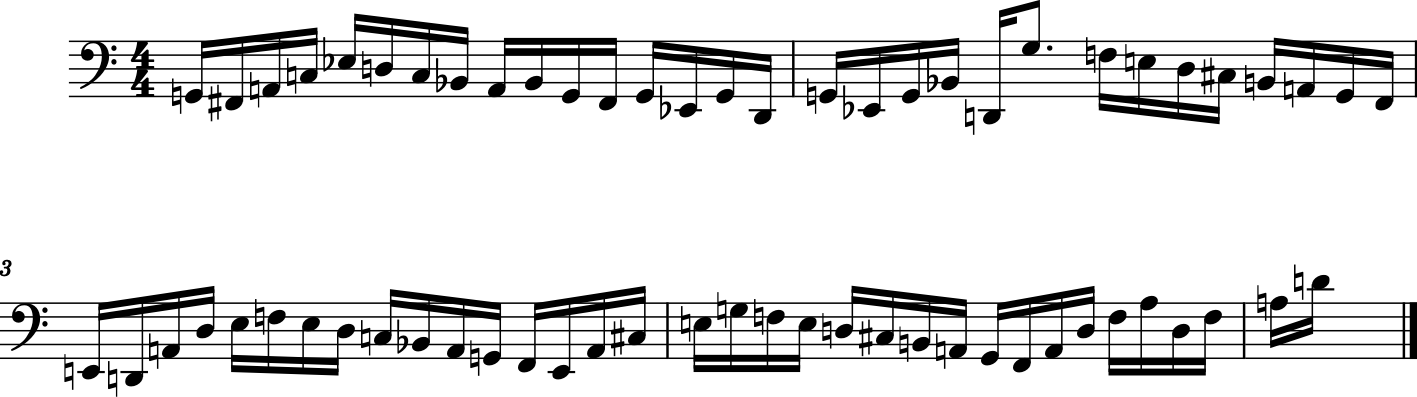

In [ ]:
rand_idx = np.random.randint(X_n.shape[0])

orig_score = music21.stream.Stream()

for n, d in zip(X_n[rand_idx], X_d[rand_idx]):
    a = music21.note.Note(n)
    a.duration.quarterLength = float(d)*1.0
    orig_score.append(a)

orig_score.show()

### Continued sequence

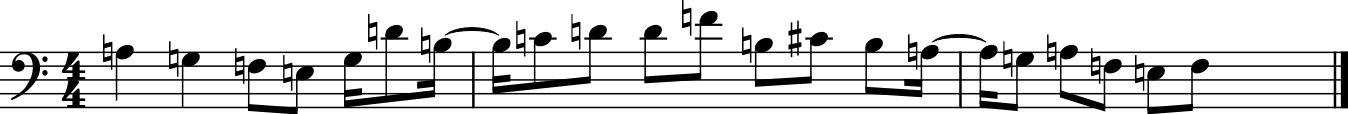

In [ ]:
pred_n, pred_d = continue_sequence(
    seq_n = X_n[0, :][np.newaxis, :],
    seq_d = X_d[0, :][np.newaxis, :],
    times=20,
    model=model
)

stream = convert_to_stream(pred_n, pred_d, dur_encoder)
stream.show()


### Combined sequence

We now combine the sequences and also save the sequence as MIDI file so we can listen to it via e.g. VLC.

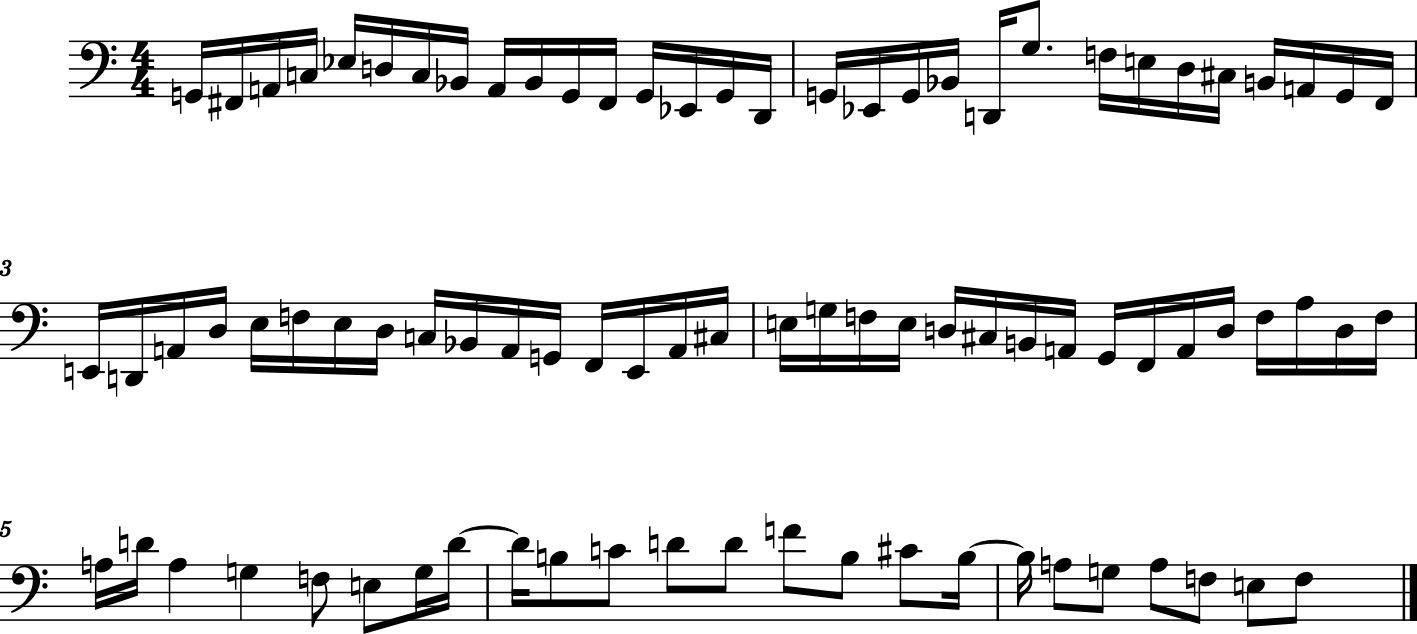

In [ ]:
con_score = music21.stream.Stream()
for n in orig_score:
    con_score.append(n)
for n in stream:
    con_score.append(n)

con_score.write('midi', 'assets/bach-model/v01/bach_continue.mid')
con_score.show()

## Making predictions in real time with SuperCollider

As a final step we want to show how one can interact with our model in real time via SuperCollider.
For this we need to establish a connection between Python, which will take care of the calculation of the next notes, and SuperCollider, which is great for interacting within a real time environment.

SuperCollider is limited to the OSC protocoll and files for outside communication so we will use the OSC protocoll here as we are awaiting a response from a system and do not need to transfer much data.
Python supports the OSC protocoll as well via the library [python-osc](https://github.com/attwad/python-osc).
We will not get much into detail what will happen here - see the OSC communication between Python and sclang chapter for more information.
Note that Python normally can only do one thing once and can not schedule something ahead of time - so once we start a server which listens to OSC messages we can not do anything else before we stop the server - this is much different to sclang.

On a sidenote: It would be possible to combine both aspects in the programming language JavaScript as there is a [TensorFlow implementation in JavaScript](https://www.tensorflow.org/js) available and also allows for async execution thanks to its [main event loop](https://www.geeksforgeeks.org/what-is-an-event-loop-in-javascript/) on which *sclang* is also based.
A demo of this from Google can be found [here](https://magenta.tensorflow.org/demos/performance_rnn/index.html) and also the [source code](https://github.com/magenta/magenta-demos/tree/main/performance_rnn) of it.

### SuperCollider part

In SuperCollider we will basically just set up a callback function when hitting a note on our MIDI keyboard and save this note to an array.
If we have enough notes collected we will send an OSC message to Python, asking for a continuation of the played phrase.
Python will then send an OSC message with the next pitch and duration information which we will send back to the MIDI keyboard - if your MIDI keyboard has no synth engine you can comment out the MIDI type of our `\neural` event which will be instead playbacked on the server.

```supercollider
// init dictionary to store variables
q = q?();

// number of notes which are collected for a prediction
q[\numNotes] = 16;
q[\timeScale] = 1.0;
// python sender
q[\pythonServer] = NetAddr.new(
	hostname: "127.0.0.1",
	port: 57340,
);

q[\storage] = ();
q[\storage][\notes] = [];
q[\storage][\durs] = [];
q[\storage][\lastNote] = TempoClock.default.beats;

q[\helper] = ();
q[\helper][\join] = {|array|
	// transforms an array to a string where
	// itmes are separated by a ","
	var string = array[0].asString;
	array[(1..array.size-1)].do({|a|
		string = string ++ $, ++ a.asString;
	});
	string;
};

// init MIDI
if(MIDIClient.initialized.not) { MIDIClient.init };
MIDIIn.connectAll;
MIDIClient.destinations;

// use one of the destinations (edit this)
q[\midiOut] = MIDIOut.newByName("MIDILINK-mini", "MIDILINK-mini");

// make special event type for clarity
Event.addEventType(\neural, {
	~type = \midi;
	//~type = \note; // uncomment this for testing without MIDI
	~midiout = q[\midiOut]; // comment this if you have no MIDI out destination at hand
	~chan = ~chan ? 0;
	currentEnvironment.play;
});

// log all incoming OSC messages for debugging
OSCFunc.trace(true, hideStatusMsg: true);

OSCdef(\listenPrediction, {|msg|
	var notes = msg[1].asString.split($,);
	var durs = msg[2].asString.split($,);
	
	Task({
		notes.do({|note, i|
			(
				type: \neural,
				note: note.asInteger,
				amp: 0.7.rand()
			).play;
			(durs[i].asFloat*q[\timeScale]).wait;
		});
	}).start;
}, "/listenPrediction");

MIDIdef.noteOn(\recordNotes, {|msg|
	q[\storage][\notes] = q[\storage][\notes] ++ [msg];
	q[\storage][\durations] = q[\storage][\durations] ++ [TempoClock.default.beats - q[\storage][\lastNote]];
	
	q[\storage][\lastNote] = TempoClock.default.beats;
	
	// send message to python if we have collected enough notes
	// and reset notes
	if(q[\storage][\notes].size>q[\numNotes], {
		q[\pythonServer].sendMsg(
			"/predict",
			q[\helper][\join].(q[\storage][\notes]),
			q[\helper][\join].(q[\storage][\durations]),
		);
		q[\storage][\notes] = [];
		q[\storage][\durations] = [];
	});
}); 
```

### Python part

In [ ]:
from pythonosc import dispatcher, osc_server, udp_client

# this needs to be the address on which sclang is listening for osc messages
# 127.0.0.1 is localhost and therefore the computer where one is working on
# the 2nd number is the port number which is default 57120
# but check this via "NetAddr.langPort" in sclange
osc_client = udp_client.SimpleUDPClient("127.0.0.1", 57120)

In [ ]:
# test communication
# you should see a message in SuperCollider that a OSC message was received
osc_client.send_message("/foo", "hello world")

In [ ]:
# test if midi works - this should play 2 sounds if you have loaded 
osc_client.send_message("/listenPrediction", ["62,64", "0.5,0.25"])

In [ ]:
def predict(unused_addr, *message):
    notes = np.array([int(c) for c in message[0].split(",")])[np.newaxis, :]
    # currently we ignore the durations, but this could be also implemented
    durs = np.repeat(0.25, notes.shape[-1])[np.newaxis, :]
    print("Start predicting: ", notes.shape, durs.shape)
    pred_n, pred_d = continue_sequence(
        seq_n=notes,
        seq_d=durs,
        times=64,
        model=model,
    )
    pred_d = invert_dur(pred_d, dur_encoder)
    print("Prediction finished: ", pred_n, pred_d)
    osc_client.send_message("/listenPrediction", [",".join([str(i) for i in pred_n]), ",".join([str(i) for i in pred_d])])


In [ ]:
osc_dispatcher = dispatcher.Dispatcher()
osc_dispatcher.map("/predict", predict)

server = osc_server.ThreadingOSCUDPServer(
    ('127.0.0.1', 57340),
    osc_dispatcher,
)

To stop the server interrupt execution of the cell (see bar above in Jupyter) or hit `ctrl+c`.

In [ ]:
try:
    print("Server is listining")
    server.serve_forever()
except KeyboardInterrupt:
    print("Stop server")
    server.server_close()

Server is listining
Start predicting:  (1, 17) (1, 17)
Prediction finished:  [53 62 62 62 64 64 64 64 64 50 57 59 61 62 61 62 64 57 69 69 67 66 64 62
 71 62 64 66 67 66 64 66 67 66 67 66 64 62 64 59 61 59 61 58 66 67 69 67
 66 64 43 59 54 66 64 64 66 67 66 67 66 64 66 67] [0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.08331298828125, 0.08331298828125, 0.5, 0.5, 0.25, 0.5, 0.25, 1.0, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Start predicting:  (1, 17) (1, 17)
Prediction finished:  [48 60 57 58 57 58 50 48 43 41 58 55 53 50 64 58 57 53 55 51 50 48 46 44
 44 41 55 57 48 55 49 51 50 47 48 62 62 60 62 64 59 60 58 57 55 57 55 53
 52 53 58 57 55 58 58 53 55 52 53 55 52 53 43 45] [0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 

## Extending

Extending this small example can be done in various ways:

* Using bigger/custom training data
* Modify the architecture of the neural net
* Take the durations into account during prediction - this is a bit tricky because we need some kind of quantising because we only allow for durations we have seen during training
* Add an [attention mechanism](https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39) to the neural net
* Using a stacked LSTM with Auto Encoders to allow for polyphonic music
